In [14]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.metrics import pairwise_distances
from scipy.linalg import eigh
import pennylane as qml
from itertools import product
from scipy.linalg import expm
from itertools import combinations as cb
from sklearn.metrics import silhouette_score as ss
from sklearn.metrics import adjusted_rand_score as ars
from sklearn.cluster import KMeans

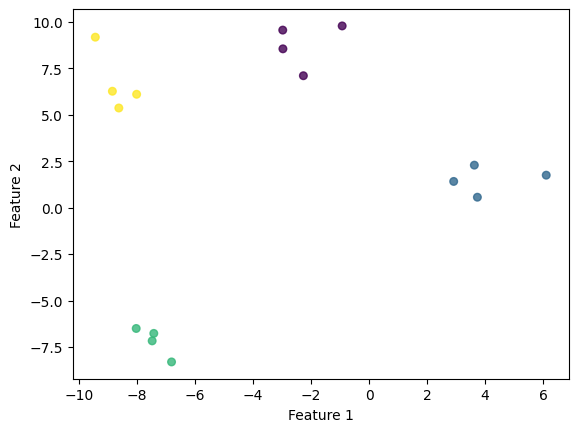

In [4]:
# data
X, Y = datasets.make_blobs(n_samples=16, centers=4, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=30, alpha=0.8)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [5]:
# adj matrix
A = np.exp(-pairwise_distances(X, metric='euclidean'))

In [6]:
D = np.diag(np.sum(A, axis=1))
L = D - A
L_inv = np.linalg.inv(L + np.eye(L.shape[0]) * 1e-6)
L_inv_norm = L_inv / np.linalg.norm(L_inv)

In [7]:
def check_divisibility(a, b):
    if a % b == 0:
        return 1
    else:
        return 0

def lcu(A):
    LCU = qml.pauli_decompose(A)
    coeff, op = LCU.terms()
    N = int(np.power(2,np.floor(math.log2(len(coeff)))))
    if check_divisibility(len(coeff), N) == 0:
        coeff, op = lcu_reduction(coeff, op, N) # variables replaced
    coeff_sqrt = np.sqrt([abs(i) for i in coeff])
    norm_coeff = coeff_sqrt / np.linalg.norm(coeff_sqrt)
    return norm_coeff, op

def lcu_reduction(coeff, op, N): # extract N top terms
    coeff = coeff[1:] # exclude the first terms
    op = op[1:]
    idx = np.argsort(coeff)[-N:][::-1]
    coeff_red = [coeff[i] for i in idx]
    op_red = [op[i] for i in idx]
    return coeff_red, op_red
    
def init_config(A, coeff):
    n_control = int(np.floor(math.log2(len(coeff))))
    n_target = int(math.log2(A.shape[0]))
    return n_control, n_target

def get_basis_state(n_qubits):
    return [list(state) for state in product([0, 1], repeat=n_qubits)]

def init_state(iter_num, input_coeff, n_target):
    if iter_num==0:
        for i in reg['target']:
            qml.Hadamard(i)
    else:
        base = get_basis_state(n_target)
        qml.Superposition(input_coeff, base, reg['target'], work_wire=reg['super_work'])

def block_encoding(coeff, op):
    qml.StatePrep(coeff, wires=reg['control'])
    qml.Select(op, control=reg['control'])
    qml.adjoint(qml.StatePrep(coeff, wires=reg['control']))

def zero_projector(n_qubits, measured_wires, outcomes):
    return [
        i for i in range(2 ** n_qubits)
        if all(format(i, f'0{n_qubits}b')[wire] == str(outcome) 
               for wire, outcome in zip(measured_wires, outcomes))]

def get_next_vec(vec, reg):
    proj_idx = zero_projector(n_tot, measured_wires=reg.tolist(), outcomes=np.zeros(len(reg), dtype=int).tolist())
    proj = np.array([vec[i] for i in proj_idx]) # project onto |0> in the control qubit
    proj = proj[0::2] # effectively remove the auxiliary qubit
    proj_norm_coeff = np.linalg.norm(proj)
    proj_norm = proj / proj_norm_coeff
    # iter_num +=1
    return proj_norm_coeff, np.real(proj), np.real(proj_norm)

def update_circuit_config(def_A):
    global A, coeff, op, n_control, n_target, n_tot, scaling_factor, dev, reg, op
    A = def_A
    coeff, op = lcu(A)
    n_control, n_target = init_config(A, coeff)
    n_tot = wires=n_control+n_target+1
    scaling_factor = sum(abs(coeff))
    dev = qml.device("default.qubit", n_tot) 
    reg = qml.registers({"control": n_control, "target": n_target, "super_work":1}) 
    op = [qml.map_wires(op_elem, {i: i + n_control for i in range(n_target)}) for op_elem in op]

In [8]:
A = coeff = op = n_control = n_target = n_tot = scaling_factor = dev = reg = op = 0
update_circuit_config(L_inv_norm)
@qml.qnode(dev)
def power_circuit(A, iter_num, coeff, op, input_coeff, n_target):
    init_state(iter_num, input_coeff, n_target)
    block_encoding(coeff, op)
    return qml.expval(qml.Hermitian(A, wires=reg['target'])), qml.state()

In [9]:
def power_method(A, num_iter=20, tol=1e-5):
    iter_num = 0
    input_coeff = 0
    proj_norm_coeffs = []
    vals = []
    vecs = []

    while iter_num < num_iter:
        val, vec = power_circuit(A, iter_num, coeff, op, input_coeff, n_target)
        proj_norm_coeff, proj, proj_norm = get_next_vec(vec, reg['control'])

        if iter_num != 1:
            proj_norm_coeffs.append(proj_norm_coeff)

        vec = np.prod(proj_norm_coeffs) * proj
        vecs.append(vec)
        val = (vec.T @ (A @ vec)) / (vec.T @ vec)
        vals.append(val)

        # stopping criteria
        if iter_num > 0 and abs(vals[-1] - vals[-2]) < tol:
            print(f"program stops at {iter_num} iteration")
            break
 
        # updates for the next iteration
        iter_num += 1
        input_coeff = proj_norm

    return vals[-1], vecs[-1]

In [10]:
def deflate(A, eig_val, eig_vec):
    return A - eig_val * qml.math.outer(eig_vec, qml.math.conj(eig_vec))

# def_val = []
def_vec = []
def_mat = A

num_eig_pair = 4 # bear in mind that the first pair lacks the ability to group data

for i in range(num_eig_pair):  
    eig_val, eig_vec = power_method(def_mat)
    # def_val.append(eig_val)
    def_vec.append(eig_vec)
    def_mat = deflate(def_mat, eig_val, eig_vec)
    update_circuit_config(def_mat)

program stops at 1 iteration
program stops at 2 iteration
program stops at 2 iteration
program stops at 3 iteration


In [11]:
for i in def_vec:
    print(i[0])

0.22445517301671059
0.12167061868040327
0.10305315323497367
0.062128430354231795


In [22]:
def get_score(X, Y, method): # ss or ard
    km = KMeans(n_clusters=4, random_state=42).fit(X)
    label_predicted = km.fit_predict(X)
    if method=='ss':
        return ss(X, label_predicted)
    elif method=='ars':
        return ars(Y, label_predicted)

def get_best_le(def_vec, Y, method):
    elem = range(len(def_vec))
    all_cb = list(cb(elem,2))
    temp_score = []
    for pair in all_cb:
        temp_data = np.stack((def_vec[pair[0]], def_vec[pair[1]]), axis=1)
        temp_score.append(get_score(X=temp_data, Y=Y, method=method))
    best_idx = np.argmax(temp_score)
    return all_cb[best_idx], np.round(temp_score[best_idx],3)

def get_best_plot(def_vec, Y, best_pair, best_score, method):
    i = best_pair[0]
    j = best_pair[1]
    plt.scatter(def_vec[i], def_vec[j], c=Y, cmap='viridis', s=30, alpha=0.8)
    plt.title(f'{method} score {best_score}')
    plt.show()

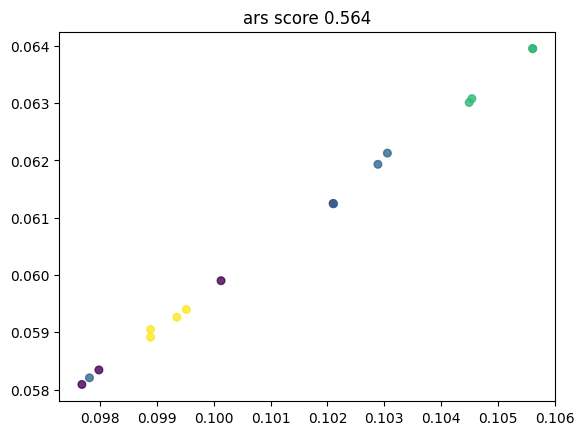

In [23]:
score_list = []
method = 'ars' # or ss
best_pair, best_score = get_best_le(def_vec, Y, method)
score_list.append(best_score)
get_best_plot(def_vec, Y, best_pair, best_score, method)